In [1]:
import datetime
import jsonlines
import os
import pandas as pd
import numpy as np
%matplotlib inline

## Build dataset

In [2]:
# Load user tweets
files = ['data/' + f for f in os.listdir("data")]
L = []
for path in files:
    with jsonlines.open(path, mode='r') as reader:
        tmp = [line for line in reader.iter()]
        L.extend(tmp)

In [4]:
raw = pd.DataFrame(L)
raw.timestamp = pd.to_datetime(raw.timestamp)
raw.head()

,id,likes,retweets,text,timestamp,url,user
0,44240662,444,779,Thinking we're only one signature away from en...,2007-04-30 08:00:00,/BarackObama/status/44240662,BarackObama
1,46195712,230,254,"Wondering why, four years after President Bush...",2007-05-02 15:00:00,/BarackObama/status/46195712,BarackObama
2,53427172,4,6,At the Detroit Economic Club – Talking about t...,2007-05-08 19:00:00,/BarackObama/status/53427172,BarackObama
3,55928192,8,4,Thinking we can cut oil consumption by 2.5 mil...,2007-05-10 05:00:00,/BarackObama/status/55928192,BarackObama
4,59358952,14,14,"In Indianola, Iowa and heading to Des Moines",2007-05-11 19:00:00,/BarackObama/status/59358952,BarackObama


In [5]:
raw.user.value_counts()

realDonaldTrump    33376
BarackObama        13417
HillaryClinton      7790
Name: user, dtype: int64

In [6]:
import re
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(u"([.!?])", r" \1", s)
    s = re.sub(u"[^a-zA-Z.!#@?\xf8\xe6\xe5]+", u" ", s)
    s = s.split(" ")
    return s

user
BarackObama        Axes(0.125,0.125;0.775x0.755)
HillaryClinton     Axes(0.125,0.125;0.775x0.755)
realDonaldTrump    Axes(0.125,0.125;0.775x0.755)
Name: timestamp, dtype: object

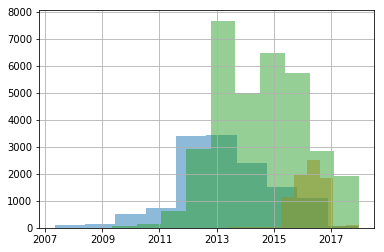

In [7]:
raw.groupby("user")['timestamp'].hist(alpha = 0.5)

user
BarackObama        Axes(0.125,0.125;0.775x0.755)
HillaryClinton     Axes(0.125,0.125;0.775x0.755)
realDonaldTrump    Axes(0.125,0.125;0.775x0.755)
Name: timestamp, dtype: object

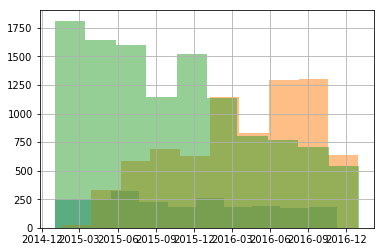

In [8]:
raw = raw[(raw.timestamp > '2015-01-01') & (raw.timestamp < '2017-01-01')]\
    .sample(frac=1)\
    .reset_index(drop=True)
    
raw.groupby("user")['timestamp'].hist(alpha = 0.5)

In [9]:
raw['normalized'] = raw.text.map(normalizeString)
all_words = np.array([item for sublist in raw['normalized'].values.tolist() for item in sublist])

In [10]:
words, counts = np.unique(all_words, return_counts=True)
keep_words = words[counts > 5]

In [49]:
ind2word = {i + 2 : w for i, w in enumerate(keep_words)}
ind2word[1] = "UNK"
ind2word[0] = "EMPTY"
word2ind = {w : i for i, w in ind2word.items()}

In [73]:
# Prepare sequences:

vectorize_tweet = lambda x: [word2ind.get(w,1) for w in x]

In [74]:
raw['text_index'] = raw.normalized.map(vectorize_tweet)

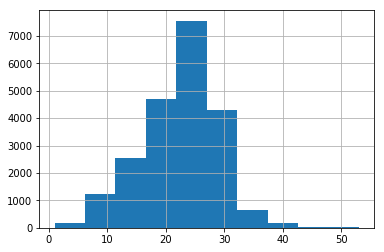

In [75]:
# Check length of tweets:
raw.text_index.map(len).hist()

In [76]:
SEQ_LENGTH = 40

from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(raw.text_index, maxlen = SEQ_LENGTH, padding = "post", truncating= "post")

In [77]:
y = (raw.user == "HillaryClinton")*1 + (raw.user == "BarackObama")*2

In [78]:
np.random.seed(42)
train_ind = np.random.rand(X.shape[0]) < 0.8
X_train = X[train_ind,]
X_test = X[~train_ind,]
y_train = y[train_ind]
y_test = y[~train_ind]

In [79]:
X_train.shape

(17087, 40)

In [80]:
vocab = len(ind2word)

## Build model

In [81]:
import keras
from keras.layers import *
from keras.models import Model

In [82]:
tweet_input = Input((SEQ_LENGTH,))

emb = Embedding(vocab, 10)

In [83]:
word_vectors = emb(tweet_input)
word_vectors = Dropout(0.5)(word_vectors)

In [86]:
avg_word_vectors = Lambda(lambda x: K.mean(x, 1))(word_vectors)
x = Dense(10)(avg_word_vectors)
x = Dense(10)(x)
x = Dropout(0.2)(x)
x = Dense(3, activation = "softmax")(x)


model = Model(inputs = tweet_input, outputs = x)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr = 0.001), 
              metrics=["accuracy"])

In [116]:

# LSTM MODEL
x = LSTM(10)(word_vectors)
x = Dense(3,activation = "softmax")(x)
model = Model(inputs = tweet_input, outputs = x)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr = 0.001), 
              metrics=["accuracy"])

In [117]:
model.fit(X_train,y_train, 
          verbose = 2,
          validation_data = (X_test, y_test),
         epochs = 5)

Train on 17087 samples, validate on 4282 samples
Epoch 1/5
65s - loss: 0.4210 - acc: 0.8347 - val_loss: 0.3158 - val_acc: 0.8725
Epoch 2/5
66s - loss: 0.2085 - acc: 0.9204 - val_loss: 0.1366 - val_acc: 0.9610
Epoch 3/5
66s - loss: 0.0906 - acc: 0.9727 - val_loss: 0.1127 - val_acc: 0.9626
Epoch 4/5
64s - loss: 0.0693 - acc: 0.9783 - val_loss: 0.1216 - val_acc: 0.9615
Epoch 5/5
65s - loss: 0.0632 - acc: 0.9813 - val_loss: 0.1170 - val_acc: 0.9645


In [118]:
yhat_probs = model.predict(X_test)

In [119]:
yhat = yhat_probs.argmax(axis=1)

In [120]:
from sklearn.metrics import confusion_matrix

In [121]:
def decode_tweet(vec):
    dec = [ind2word.get(ind) for ind in vec if ind != 0]
    
    return " ".join(dec)

In [122]:
decode_tweet(X_test[1,])

' @anncoulter i think donaldtrump has struck a UNK ! macy s customers UNK in support of donald trump http bit .ly UNK '

In [123]:
confusion_matrix(y_test,yhat)

array([[2259,   58,    2],
       [  63, 1468,    8],
       [   0,   21,  403]])

In [124]:
thought_was_trump_but_was_hillary = X_test[(y_test.values == 0) & (yhat == 1),]

for vec in thought_was_trump_but_was_hillary:
    print(decode_tweet(vec))

pic .twitter .com UNK UNK
 everything comes to him who UNK while he UNK . UNK UNK
 UNK UNK @foxandfriends mr . trump calls it like it is . hrc should be UNK UNK and put in federal prison . 
via UNK by UNK UNK donald trump talks gun control assault weapons gun free zones self defense http www UNK .com donald trump talks gun control assault weapons gun free zones #ixzz UNK 
mike pence won big . we should all be proud of mike !
 @ a e f e UNK ya es UNK y tenemos con que @realdonaldtrump pic .twitter .com UNK nd un 
off to nashville and the nra .
six hours left to #votetrump connecticut !pic .twitter .com u UNK
great night in wi . i m going to fight for every person in this country who believes government should serve the people not the donors !pic .twitter .com ac UNK UNK 
in business you make decisions that are in your best interests . time for the us gov t to do the same . let s make america great again !
for those few people knocking me for tweeting at three o clock in the morning at l

In [97]:
yhat

array([0, 0, 1, ..., 0, 0, 0])